# Patch visualization

This notebook can be used to look at the patches generated using `patch_generation.py`. 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
import math
import os
import natsort
from tqdm.notebook import tqdm as tqdm

Run the following cell if you want the plots to be interactive. You might need to run the cell twice.

In [2]:
%matplotlib notebook
# To revert it:
#%matplotlib inline

In [3]:
def plot_patch(patch, padding=None, ax=None):
    """ Plot a patch as a surface in 3D.

    Args:
        patch (np.array): Patch to plot
        padding (tupple): Optional, specify the padding around the patch, to be able
        to display it. The padding is specified as (back, front, left, right)
        ax (matplotlib axes): Optional, pass this if you want to plot inside a specific axes.
    """
    
    X = np.arange(patch.shape[1])
    Y = np.arange(patch.shape[0])
    X, Y = np.meshgrid(X, Y)
    
    colors = np.full((*patch.shape, 3), [0.6, 0.7, 0.9])
    
    if padding is not None:
        colors[padding[2]:-padding[3], padding[0]:-padding[1]] = [0.2, 0.1, 0.9]

    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')

    surf = ax.plot_surface(X, Y, patch, rstride=1, cstride=1, facecolors=colors, linewidth=1)
    
    if ax is None:
        plt.show()

## Example

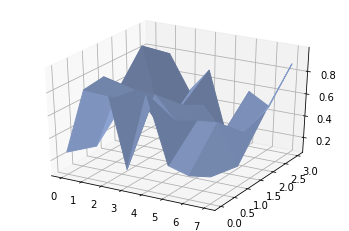

In [4]:
patch=np.random.random((4, 8))

plot_patch(patch)

**Be careful, it is not possible to easily change the aspect ratios in 3D with Matplotlib, hence the visualization is scaled in the x,y,z direction.**

## Plot a patch saved as HDF5

Here is how you can inspect a patch generated with `patch_generation.py`.

In [5]:
def load_hdf5_patch(path):
    with h5py.File(path, 'r') as hdf5_file:
        patch = hdf5_file['patch'][:]
        padding = hdf5_file['patch_padding'][:]
    
    return patch, padding

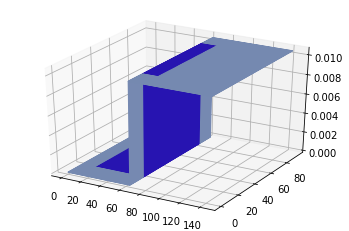

In [6]:
patch, padding = load_hdf5_patch('/data/havy/shared_folder/patches/steps/step150.hdf5')

plot_patch(patch, padding)

The dark area is the actual patch, and the light area is the padding around it for the simulation.

**The vertical scale is incorrect !**

## Plot all the patches in a folder

In [7]:
def find_and_plot_all(folder_path, patch_extension='hdf5', subset=None, patches_per_line=5):
    
    patches =  natsort.natsorted([(os.path.splitext(f.name)[0], os.path.realpath(f.path)) for f in os.scandir(folder_path) \
                                 if f.is_file() and f.name.endswith('.' + patch_extension)], key=lambda x: x[0])
    
    if len(patches) == 0:
        return
    
    if subset:
        if type(subset) is list:
            patches = patches[subset[0]:subset[1]]
        else:
            patches = patches[:subset]
            
    nb_lines = int(math.ceil(len(patches) / patches_per_line))
    
    fig, axs = plt.subplots(nb_lines, patches_per_line, figsize=(15,15), 
                            subplot_kw=dict(projection='3d'))
    
    patch_progress_bar = tqdm(total=len(patches), desc='Patches plotted')
    
    for ax, patch_info in zip(axs.flatten(), patches):
        patch_name = patch_info[0]
        filepath = patch_info[1]
        
        # Load patch
        patch, padding = load_hdf5_patch(filepath)
        
        plot_patch(patch, padding, ax)
        ax.set_title(patch_name)
        
        patch_progress_bar.update(1)
        
    patch_progress_bar.close()
    
    fig.show()

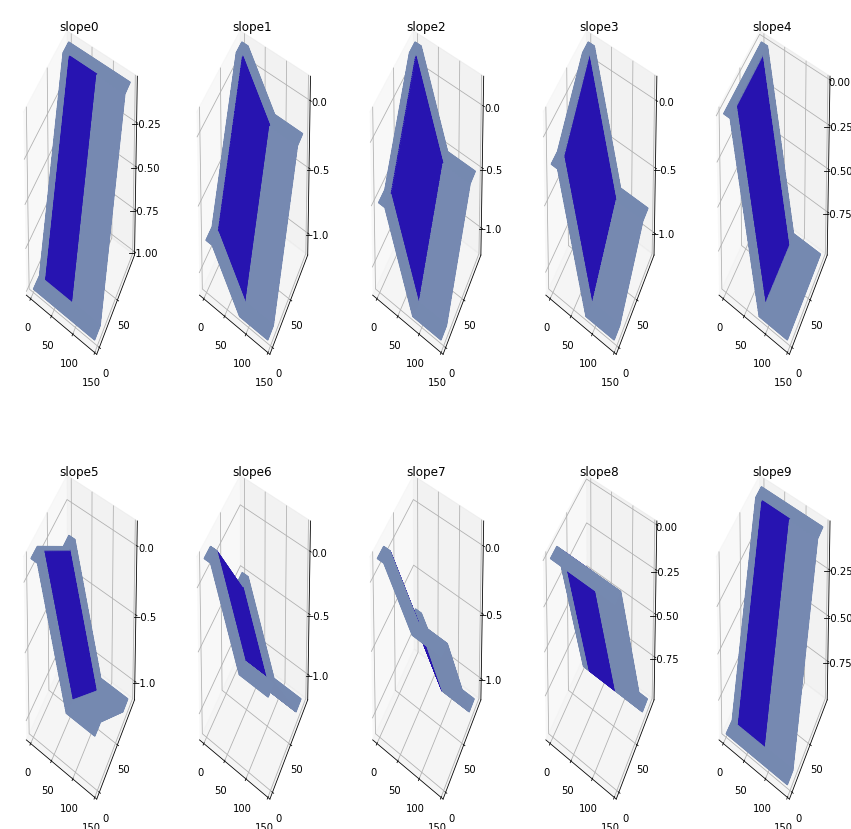

In [8]:
find_and_plot_all('/data/havy/shared_folder/patches/slopes/', subset=[0, 10])